# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [37]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

In [38]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [39]:
# Let's have a peak into the dataset
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [40]:
azdias.shape

(891221, 85)

In [41]:
# Information related to features of azdias
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [42]:
feat_info.shape

(85, 4)

## Step 1: Preprocessing

In [43]:
# We interpret the missing_or_unknown column of the feat_info DataFrame as a list and replace the corresponding values
# in the azdias DataFrame with np.NaN

import ast
import re

for c in feat_info.iterrows():
    #https://stackoverflow.com/questions/1894269/convert-string-representation-of-list-to-list
    str = c[1]['missing_or_unknown']
    
    if str == '[]':
        continue
        
    # Add quotes to string so they can be interpreted as lists
    str = re.sub(r"([A-Za-z])",r"'\1'",str)
    
    try:
        mlist = ast.literal_eval(str)
        azdias[c[1]['attribute']][azdias[c[1]['attribute']].isin(mlist)] = np.NaN
    except ValueError:
        print('Could not be interpreted as a list: {}'.format(str))

#### Step 1.1.2: Assess Missing Data in Each Column

In [44]:
# Count NaNs in each column

nancl = []

for c in azdias.columns:
    l = azdias[c].value_counts(dropna=False,normalize=True)
    try:
        nancl.append(l[np.NaN])
    except TypeError:
        nancl.append(0)

<Container object of 85 artists>

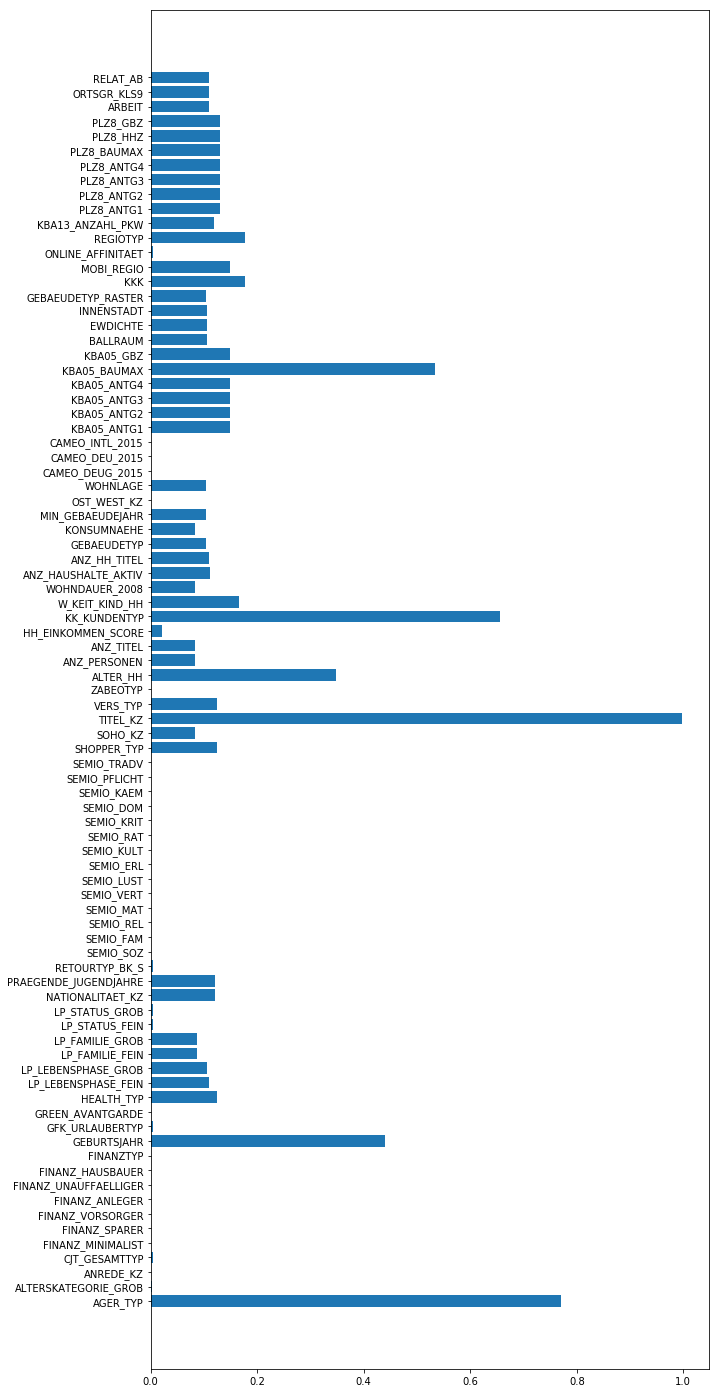

In [45]:
fig, ax = plt.subplots(figsize=(10,25))
y = np.arange(len(azdias.columns))
ax.barh(y,nancl,tick_label=azdias.columns)

In [46]:
# Print Columns with more than 20% missing values

for c in azdias.columns:
    l = azdias[c].value_counts(dropna=False,normalize=True)
    try:
        if l[np.NaN] >= 0.2:
            print(c)
    except TypeError:
        continue

AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


In [47]:
# Remove columns with over 20% missing values
try:
    azdias = azdias.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)
except KeyError: # Already Dropped
    pass

In [48]:
#Let's build a dataframe where the rows signify each column in azdias. The columns denote all other columns,
#which are 'NaN' if the column in the row is also NaN

corr_l = []
na_df = azdias.isna()
for c in na_df.columns:
    entry = na_df.loc[na_df[c]==True].sum().to_dict()
    entry['index'] = c
    corr_l.append(entry)

In [49]:
corr_df = pd.DataFrame(corr_l)
corr_df = corr_df.set_index('index')

In [50]:
corr_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEU_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
index,,,,,,,,,,,,,,,,,,,,,
ALTERSKATEGORIE_GROB,2881,0,97,92,0,0,96,78,95,95,...,0,0,0,2881,0,2881,0,78,754,0
ANREDE_KZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CJT_GESAMTTYP,15,0,103,100,0,0,126,102,133,133,...,0,0,0,276,0,276,0,100,217,0
FINANZ_MINIMALIST,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FINANZ_SPARER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For example there are 92 rows where 'ALTERSKATEGORIE_GROB' is NaN and 'ANZ_HH_TITEL' is NaN

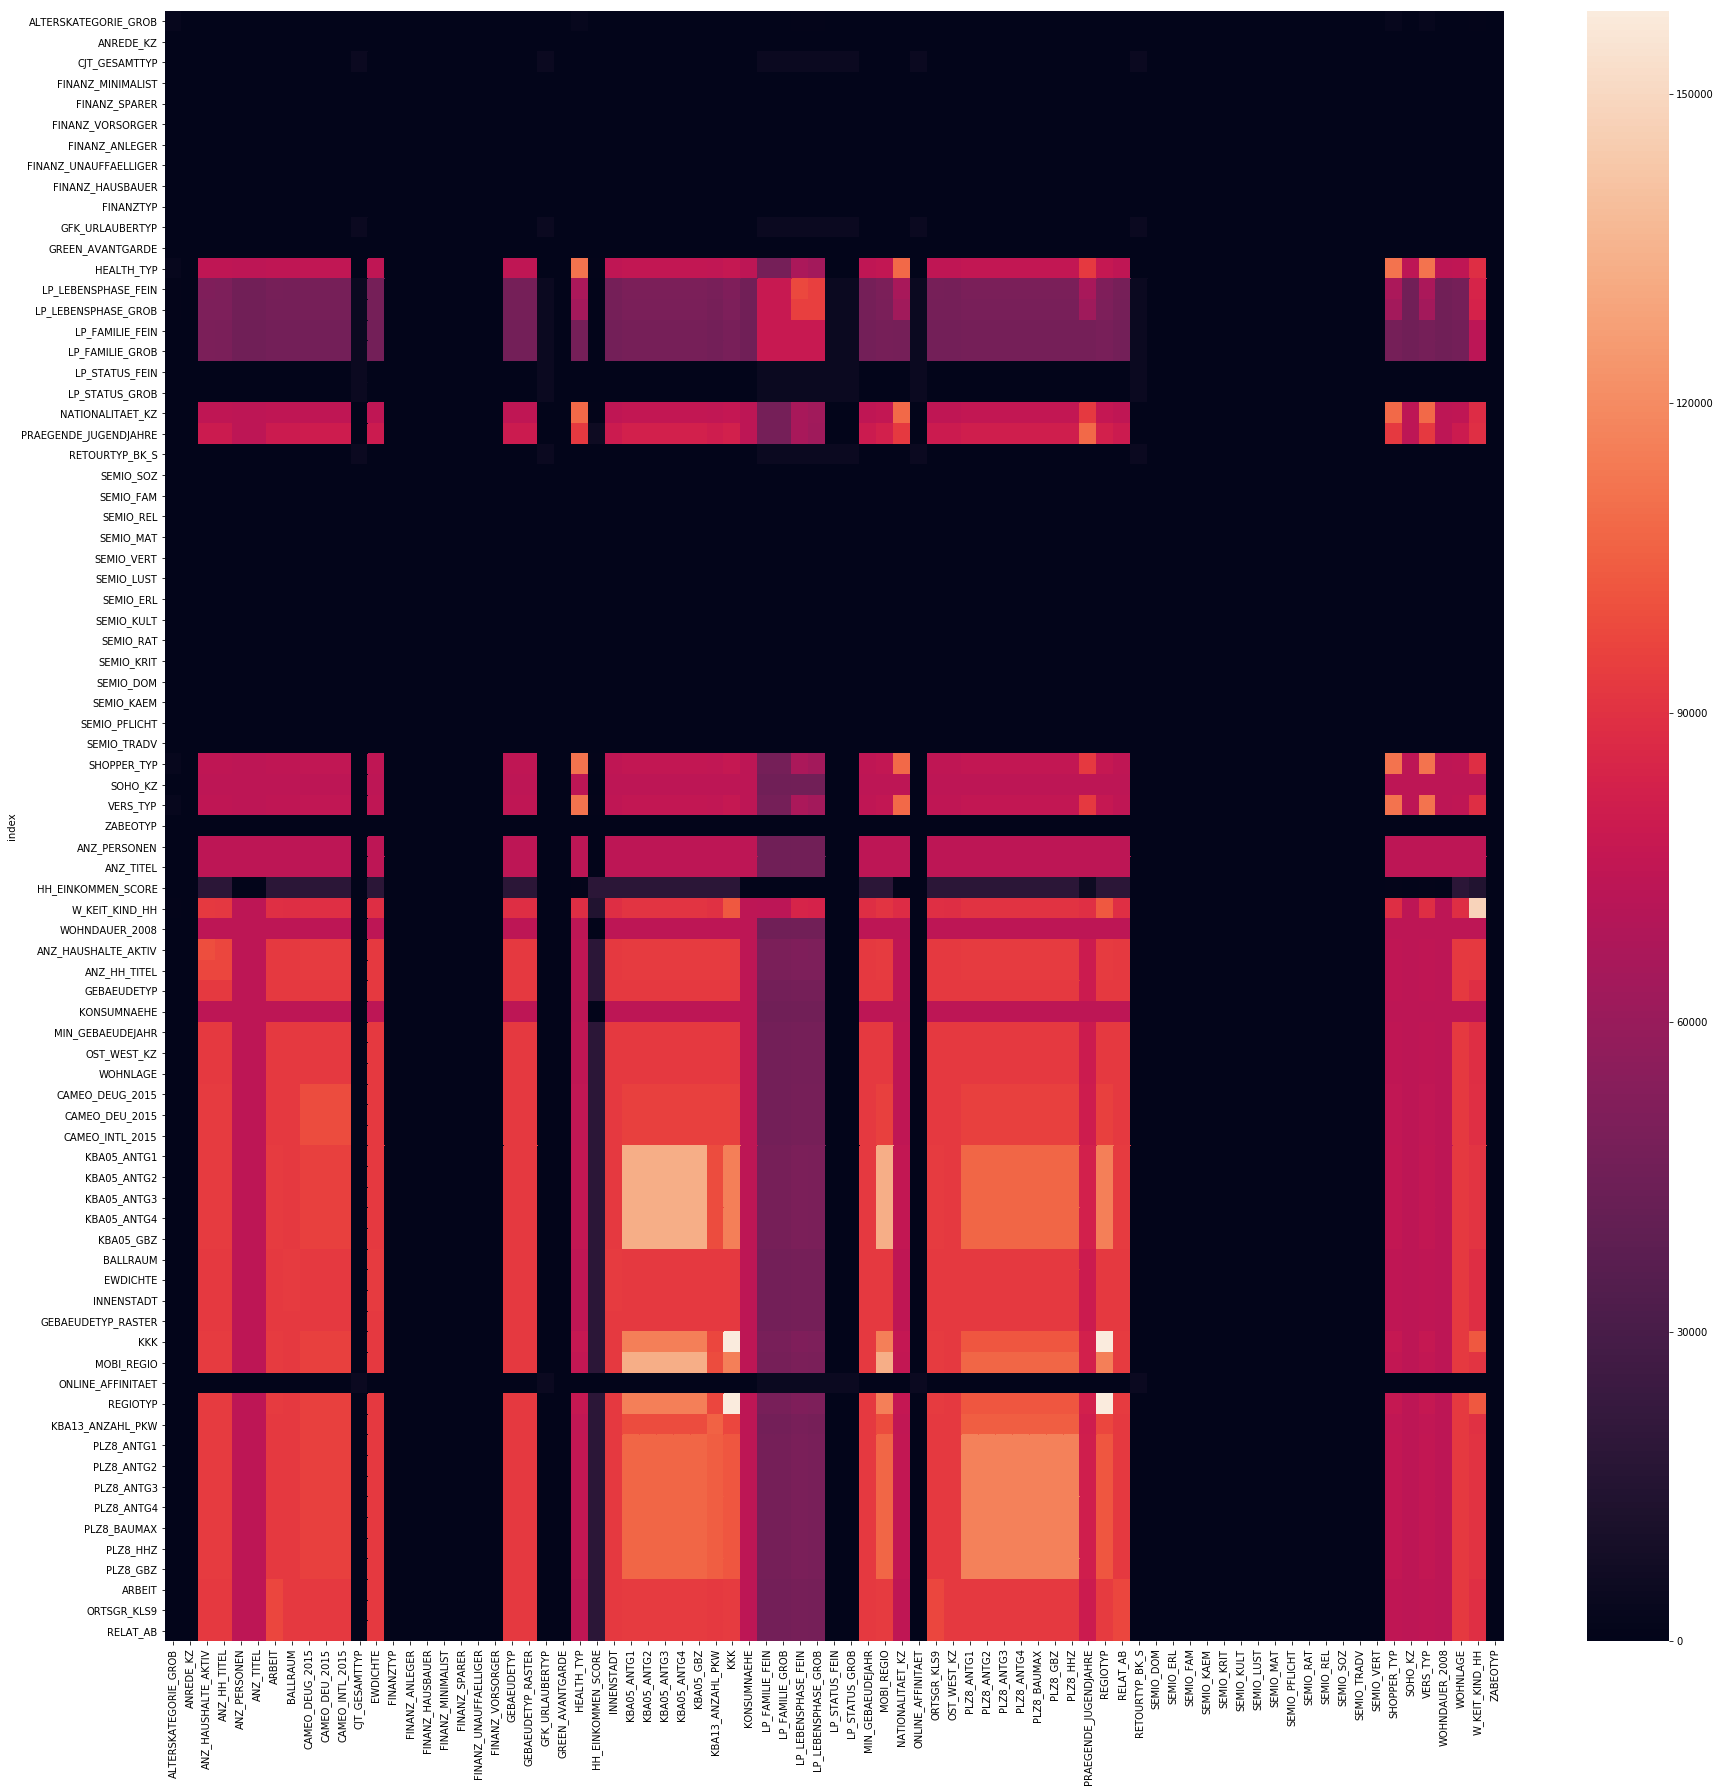

In [51]:
import seaborn as sb

fig,ax = plt.subplots(figsize=(30,30))
sb.heatmap(corr_df,ax=ax)

### Heatmap Explanation
The y-Axis are the row labels and the x-Axis the corresponding other columns which are Nan . Black Rows denote the case where the index label is a NaN, but no other values are NaN or have much lower NaN counts than other rows.

Black Columns in the plot denote the case that these labels are never NaN when another label is NaN. Since all of them are also crossing 'themselves' row-wise, too, the corresponding label is nowhere a 'NaN'. Black is synonymous with 'relatively few' on the color scale used here. 

High counts denote regions, where a NaN on the y-axis is correlated with NaNs in the labels on the x-axis. This means, if the column on the left is NaN, many columns in the column denoted in the x-Axis are also NaN.

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the 'correlation map', we can see that if one 'KBA05_' or 'PLZ8_' value is missing, all other values of these categories are also missing. A missing 'KBA05_' value has likely also a missing 'MOBI_REGION' value. Counting the missing values per column, it becomes clear that some features were not taken with the same diligence than others by a rather large margin. All columns with more than 20% missing values are dropped.

#### Step 1.1.3: Assess Missing Data in Each Row

Text(0,0.5,'Rows')

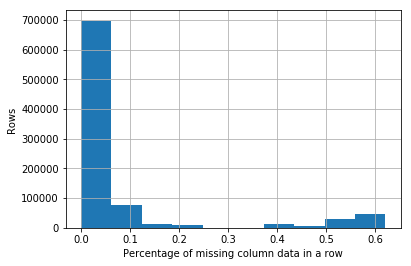

In [52]:
ax = (azdias.isna().sum(axis=1)/azdias.shape[1]).hist()

ax.set_xlabel('Percentage of missing column data in a row')
ax.set_ylabel('Rows')

In [53]:
# Divide rows in two sets: One with more than 30% missing columns, one with less
crit = azdias.isna().sum(axis=1)/azdias.shape[1] <= 0.3
set1 = azdias.loc[crit].copy()
set2 = azdias.loc[~crit].copy()

In [54]:
set1.isna().sum(axis=1).value_counts()

0     623209
2      27926
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
10      5410
15      4743
13      3255
9       3042
16      2505
14      2243
19      1180
11      1127
12       766
17       677
18       428
20       349
21       150
23       132
22       129
dtype: int64

In [55]:
set1.shape

(797837, 79)

In [56]:
set2.shape

(93384, 79)

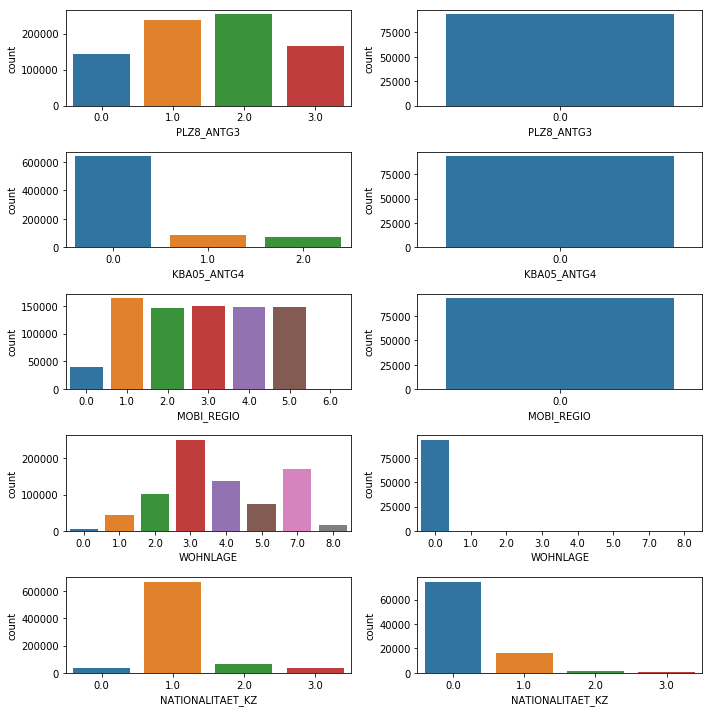

In [57]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
import seaborn as sb

# Based on heatmap above
cols=['PLZ8_ANTG3','KBA05_ANTG4','MOBI_REGIO','WOHNLAGE','NATIONALITAET_KZ']

fig, ax = plt.subplots(len(cols),2,figsize=(10,10))

for i,c in enumerate(cols):
    #Reverse filling in NaN for plotting, 0 is not reserved for another value
    sb.countplot(ax=ax[i,0],x=c,data=set1.replace(np.NaN,0))
    sb.countplot(ax=ax[i,1],x=c,data=set2.replace(np.NaN,0))

plt.tight_layout()

#### Discussion 1.1.3: Assess Missing Data in Each Row

Similar to the observation from the heatmap, we can see that the missing data is mainly related to real estate data (PLZ8_ and KBA05_). MOBI_REGIO and WOHNLAGE, the mobility of the person, is also missing simultaneously. The similariaty of the features probably means that they all come from a similar source. The nationality is missing more, but is not missing completely like the others.

### Step 1.2: Select and Re-Encode Features

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


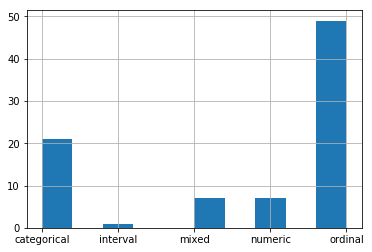

In [58]:
# How many features are there of each data type?
print(feat_info['type'].value_counts())
feat_info['type'].hist()

#### Step 1.2.1: Re-Encode Categorical Features

In [59]:
feat_info['attribute'].loc[feat_info['type'] == 'categorical']

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [60]:
cols= feat_info['attribute'].loc[feat_info['type'] == 'categorical']

for c in cols:
    try:
        print('{} : {}'.format(c,set1[c].unique()))
    except KeyError: # We already dropped this column
        continue

ANREDE_KZ : [2 1]
CJT_GESAMTTYP : [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP : [1 6 5 2 4 3]
GFK_URLAUBERTYP : [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE : [0 1]
LP_FAMILIE_FEIN : [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB : [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN : [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB : [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ : [  1.   3.   2.  nan]
SHOPPER_TYP : [  3.   2.   1.   0.  nan]
SOHO_KZ : [ 1.  0.]
VERS_TYP : [  2.   1.  nan]
ZABEOTYP : [5 3 4 1 6 2]
GEBAEUDETYP : [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ : ['W' 'O']
CAMEO_DEUG_2015 : ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 : ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [61]:
set1[['CAMEO_DEU_2015','CAMEO_DEUG_2015']].head(20) # Making sure that the 'grob' columns have the same information as the 'fein' ones

,CAMEO_DEU_2015,CAMEO_DEUG_2015
1,8A,8
2,4C,4
3,2A,2
4,6B,6
5,8C,8
6,4A,4
7,2D,2
8,1A,1
9,1E,1
10,9D,9


In [62]:
# We can drop the 'grob' columns as the 'fein' columns have the same information, this is also based on the Data dictionary
set1a = set1.drop(['CAMEO_DEUG_2015', 'LP_STATUS_GROB','LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB'],axis=1).copy()

In [63]:
# Re-encode categorical variable(s) all non-binary categories
# This is kept here, but ultimately left out of the final cleaning procedure, since it dramatically saves time for KMeans
reenc = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEU_2015']
enc_set1a = pd.get_dummies(set1a,columns=reenc)

In [64]:
enc_set1a['OST_WEST_KZ'] = enc_set1a['OST_WEST_KZ'].replace({'W': 1,'O': 0})

#### Discussion 1.2.1: Re-Encode Categorical Features

We checked which features are categorical by comparing it with the given features dataset. Features which had only two possible values were categorized as 'binary' and not modified. Features with two values and 'NaN' were also categorized as 'binary', since the 'NaN' will be imputed later or the rows will be entirely dropped. Redundant columns were dropped. Multi-categorical features were re-encoded. However, as mentioned above, this re-encoding was ultimately left out of the analysis to save computing time for the KMeans algorithm. The OST_WEST_KZ binary value was adapted to have numerical values.

#### Step 1.2.2: Engineer Mixed-Type Features

In [65]:
# Check for mixed features
feat_info['attribute'].loc[feat_info['type'] == 'mixed']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [66]:
cols= feat_info['attribute'].loc[feat_info['type'] == 'mixed']

for c in cols:
    try:
        print('{} : {}'.format(c,enc_set1a[c].unique()))
    except KeyError: # We already dropped this column
        continue

LP_LEBENSPHASE_FEIN : [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  11.
  25.  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.
  39.  27.  36.   9.  34.  33.  15.  40.  16.  19.  17.]
PRAEGENDE_JUGENDJAHRE : [ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]
WOHNLAGE : [ 4.  2.  7.  3.  5.  1.  8.  0.]
CAMEO_INTL_2015 : ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX : [  1.   2.  nan   4.   5.   3.]


In [67]:
# I tried my best to not create modifiable slices of dataframes which are used to index here
# but the warning still came up. I understnad the issus. Maybe a false positive ? Switch it off for now.
# See https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

#This cell breaks up the features 'PRAEGENDE_JUGENDJAHRE' and engineers new features based on them

pd.options.mode.chained_assignment = None  # default='warn'

# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
move_type = {'mainstream':[1,3,5,8,10,12,14],'avantgarde':[2,4,6,7,9,11,13,15]}
dec_type = {'40s':[1,2],'50s':[3,4],'60s':[5,6,7],'70s':[8,9],'80s':[10,11,12,13],'90s':[14,15]}
unknown = [-1,0,np.NaN]
enc_set1a['PJ_MOVE'] = 0

enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(move_type['mainstream'])]['PJ_MOVE']=1
enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(move_type['avantgarde'])]['PJ_MOVE']=0

enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['40s'])]['PJ_DEC']=1
enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['50s'])]['PJ_DEC']=2
enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['60s'])]['PJ_DEC']=3
enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['70s'])]['PJ_DEC']=4
enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['80s'])]['PJ_DEC']=5
enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['90s'])]['PJ_DEC']=6

enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(unknown)]['PJ_MOVE']= np.NaN
enc_set1a[enc_set1a['PRAEGENDE_JUGENDJAHRE'].isin(unknown)]['PJ_DEC']= np.NaN

In [68]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
cameo =  enc_set1a['CAMEO_INTL_2015'].astype(float)
enc_set1a['WEALTH'] = np.floor(cameo / 10)
enc_set1a['LIFE_STAGE'] = cameo - enc_set1a['WEALTH']*10

In [69]:
# Sanity Check
enc_set1a[['WEALTH','LIFE_STAGE','CAMEO_INTL_2015']].head()

,WEALTH,LIFE_STAGE,CAMEO_INTL_2015
1,5.0,1.0,51
2,2.0,4.0,24
3,1.0,2.0,12
4,4.0,3.0,43
5,5.0,4.0,54


#### Discussion 1.2.2: Engineer Mixed-Type Features

We engineered new features out of 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' based on the instructions. 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' will be dropped later as they became redundant and confusing.

#### Step 1.2.3: Complete Feature Selection

In [71]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
enc_set1a.drop('CAMEO_INTL_2015',axis=1)
enc_set1a = enc_set1a.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

### Step 1.3: Create a Cleaning Function

In [72]:
import ast
import re
pd.options.mode.chained_assignment = None  # default='warn'

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # convert missing value codes into NaNs, ...
    for c in feat_info.iterrows():
        #https://stackoverflow.com/questions/1894269/convert-string-representation-of-list-to-list
        str = c[1]['missing_or_unknown']

        if str == '[]':
            continue

        # Add quotes to string so they can be interpreted as lists
        str = re.sub(r"([A-Za-z])",r"'\1'",str)

        try:
            mlist = ast.literal_eval(str)
            df[c[1]['attribute']][df[c[1]['attribute']].isin(mlist)] = np.NaN
        except KeyError:
            continue
                
    # remove selected columns and rows, ...
    
    # Remove columns with over 20% missing values
    df = df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'],axis=1)
             
    # Orignally, this was the code to remove columns with too many missing values. However, the criterion doesn't fit
    # to the customer data set, which leads to inconsistency between the general demographic and customer dataset
    #     for c in df.columns:
    #         l = df[c].value_counts(dropna=False,normalize=True)
    #         try:
    #             if l[np.NaN] >= 0.2:
    #                 #print(' Deleting col {}'.format(c))
    #                 df.drop(c,inplace=True,axis=1)
    #         except TypeError:
    #             continue 
            
    crit = df.isna().sum(axis=1)/df.shape[1] <= 0.3
    
    #Return deletec rows to create additional cluster after applying KMeans
    deleted_rows = df.loc[~crit]
    
    df = df.loc[crit].copy()
    
    # select, re-encode, and engineer column values.

    # We can drop the 'grob' columns as the 'fein' columns have the same information, this is also based on the Data dictionary
    try:
        df = df.drop(['CAMEO_DEUG_2015', 'LP_STATUS_GROB','LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB'],axis=1).copy()
    except KeyError:
        df = df.drop(['CAMEO_DEUG_2015', 'LP_STATUS_GROB'],axis=1).copy()
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    move_type = {'mainstream':[1,3,5,8,10,12,14],'avantgarde':[2,4,6,7,9,11,13,15]}
    dec_type = {'40s':[1,2],'50s':[3,4],'60s':[5,6,7],'70s':[8,9],'80s':[10,11,12,13],'90s':[14,15]}
    unknown = [-1,0,np.NaN]
    
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        # Create empty column
        df['PJ_MOVE'] = 0
        df['PJ_DEC'] = 0

        df[df['PRAEGENDE_JUGENDJAHRE'].isin(move_type['mainstream'])]['PJ_MOVE']=1
        df[df['PRAEGENDE_JUGENDJAHRE'].isin(move_type['avantgarde'])]['PJ_MOVE']=0

        df[df['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['40s'])]['PJ_DEC']=1
        df[df['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['50s'])]['PJ_DEC']=2
        df[df['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['60s'])]['PJ_DEC']=3
        df[df['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['70s'])]['PJ_DEC']=4
        df[df['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['80s'])]['PJ_DEC']=5
        df[df['PRAEGENDE_JUGENDJAHRE'].isin(dec_type['90s'])]['PJ_DEC']=6

        df[df['PRAEGENDE_JUGENDJAHRE'].isin(unknown)]['PJ_MOVE']= np.NaN
        df[df['PRAEGENDE_JUGENDJAHRE'].isin(unknown)]['PJ_DEC']= np.NaN

        df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
        
    unknown = ['XX',np.NaN]

    cameo =  df['CAMEO_INTL_2015'].astype(float)
    df['WEALTH'] = np.floor(cameo / 10)
    df['LIFE_STAGE'] = cameo - df['WEALTH']*10
    
    df[df['CAMEO_INTL_2015'].isin(unknown)]['WEALTH']= np.NaN
    df[df['CAMEO_INTL_2015'].isin(unknown)]['LIFE_STAGE']= np.NaN

    reenc = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEU_2015']
    
    # Initially, these features were hot-encoded, but actually the feature size becomes too large to be handled by KMeans in a reasonable time
    #df = pd.get_dummies(df,columns=reenc)
    
    for c in reenc:
        if c in df.columns:
            df = df.drop(c,axis=1)
        else:
            continue

    df = df.drop('CAMEO_INTL_2015',axis=1)

    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 1,'O': 0})
    
    # Return the cleaned dataframe.
    
    return df, deleted_rows
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

In [74]:
#To have a good checkpoint, we reload the data here

# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [75]:
cleanaz, cleanaz_del_rows = clean_data(azdias)

In [77]:
# How many rows have how many missing columns?
cleanaz.isna().sum(axis=1).value_counts(normalize=True)

0     0.788927
2     0.077980
3     0.036916
8     0.022078
4     0.018105
6     0.014900
1     0.012069
15    0.005658
7     0.004144
13    0.003481
16    0.003255
5     0.002408
14    0.002407
10    0.001910
9     0.001786
18    0.001663
11    0.000889
17    0.000563
12    0.000559
19    0.000202
20    0.000081
21    0.000020
dtype: float64

In [80]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy = 'mean')
imputed = imputer.fit_transform(cleanaz)
impaz = pd.DataFrame(imputed,columns=cleanaz.columns,index=cleanaz.index)

In [81]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaledaz = pd.DataFrame(scaler.fit_transform(impaz),columns=impaz.columns,index=impaz.index)

### Discussion 2.1: Apply Feature Scaling

The data is cleaned as discussed in the preceding sections. Remaining NaN values are imputed with the mean not to obscure trends in the final analysis. Features are scaled with the typical StandardScaler to remove bias on the weights of the features.

### Step 2.2: Perform Dimensionality Reduction

In [85]:
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    fig, ax = plt.subplots(1,2,figsize=(20, 6))
    
    cumvals = np.cumsum(vals)
    ax[0].bar(ind, vals)
    ax[1].plot(ind, cumvals)
 
    ax[0].set_xlabel("Principal Component")
    ax[0].set_ylabel("Variance Explained (%)")
    
    ax[1].set_xlabel("Principal Component")
    ax[1].set_ylabel("Cumulative Variance Explained (%)")
    
    ax[0].set_title('Explained Variance Per Principal Component')

In [84]:
# Apply PCA to the data
from sklearn.decomposition import PCA

pca = PCA()
az_pca = pca.fit_transform(scaledaz)

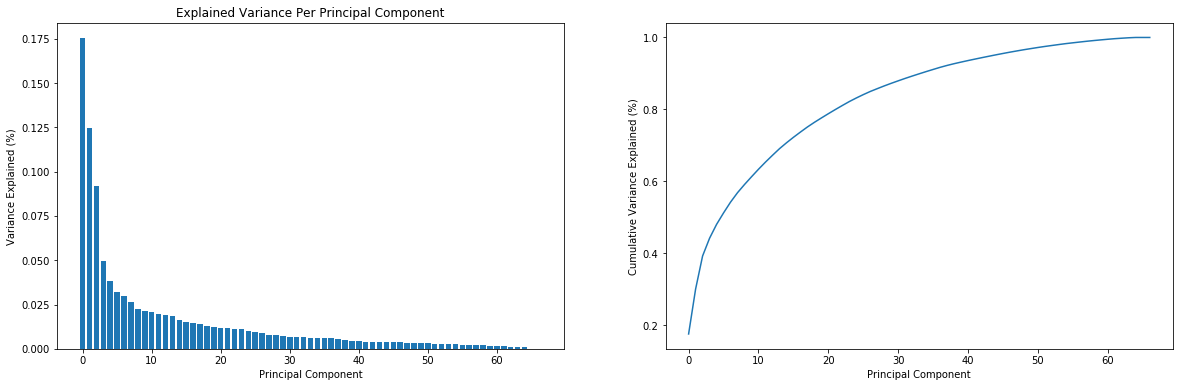

In [86]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [12]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Apply PCA to the data
from sklearn.decomposition import PCA

pca = PCA(n_components=30)
az_pca = pca.fit_transform(scaledaz)

### Discussion 2.2: Perform Dimensionality Reduction

The scree plot does not a give good feature to cut off the number of components. Thus, we choose to 20 components to explain 80% of the variance in total, which is a general rule of thumb.

### Step 2.3: Interpret Principal Components

In [14]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_pca_weight(pca, comp, cols,n_feat=3):
    idx = np.argsort(-pca.components_[comp])[:n_feat]
    
    print('*** Positive Correlation ***')
    for i in idx:
        print('{} : {}'.format(cols[i],pca.components_[comp][i]))
        
    idx = np.argsort(pca.components_[comp])[:n_feat]
    
    print('*** Negative Correlation ***')
    for i in idx:
        print('{} : {}'.format(cols[i],pca.components_[comp][i]))
    
print_pca_weight(pca,0,cleanaz.columns)

*** Positive Correlation ***
PLZ8_ANTG3 : 0.23368025335929565
PLZ8_ANTG4 : 0.22765245336339915
PLZ8_BAUMAX : 0.22255544445734302
*** Negative Correlation ***
MOBI_REGIO : -0.2417679043676197
PLZ8_ANTG1 : -0.23234890015820758
KBA05_ANTG1 : -0.22367239176628909


In [ ]:
# *** Positive Correlation ***
# PLZ8_ANTG3 : Number of 6-10 family houses in the PLZ8 region
# PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region
# PLZ8_BAUMAX : Most common building type within the PLZ8 region. The higher the more families per home
# *** Negative Correlation ***
# MOBI_REGIO : MOBI_REGIO Movement patterns. The higher, the lower the movement
# PLZ8_ANTG1 : PLZ8_ANTG1. Number of 1-2 family houses in the PLZ8 region
# KBA05_ANTG1 : KBA05_ANTG1. Number of 1-2 family houses in the microcell

In [15]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weight(pca,1,cleanaz.columns)

*** Positive Correlation ***
ALTERSKATEGORIE_GROB : 0.2803246601298474
SEMIO_ERL : 0.2604078047366724
FINANZ_VORSORGER : 0.24399687123973013
*** Negative Correlation ***
SEMIO_REL : -0.28606724727173294
FINANZ_SPARER : -0.25327522339165265
SEMIO_KULT : -0.2532608999341279


In [ ]:
# *** Positive Correlation ***
# ALTERSKATEGORIE_GROB : Estimated age based on given name analysis. The higher the higher the age
# SEMIO_ERL : Personality typology, event-oriented, the higher the less affinity
# FINANZ_VORSORGER : Financial typology, "be prepared", the higher, the lower the correspondence
# *** Negative Correlation ***
# SEMIO_REL : Personality typology, 'religious', the higher the less affinity
# FINANZ_SPARER : Financial typology, 'money-saver', the higher, the lower the correspondence
# SEMIO_KULT : Personality typology, 'cultural-minded', the higher the less affinity

In [16]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weight(pca,2,cleanaz.columns)

*** Positive Correlation ***
SEMIO_VERT : 0.34374296556722417
SEMIO_SOZ : 0.2512100989934262
SEMIO_FAM : 0.22792310765030255
*** Negative Correlation ***
ANREDE_KZ : -0.3634209202705402
SEMIO_KAEM : -0.3312005237612689
SEMIO_DOM : -0.31097956524327336


In [ ]:
# *** Positive Correlation ***
# SEMIO_VERT : Personality typology, dreamful,the higher the less affinity
# SEMIO_SOZ : socially-minded
# SEMIO_FAM :  family-minded
# *** Negative Correlation ***
# ANREDE_KZ : Gender 1: male 2: female
# SEMIO_KAEM : combative attitude
# SEMIO_DOM : dominant-minded

### Discussion 2.3: Interpret Principal Components

- First PCA Component
This component is positively correlated with high persons/house while being negatively correlated with low mobility (= pos. with high mobility), high number of buildings and houses with low family count. It seems this is a feature that correlates with neighborhoods with many families per house and high turnover.

- Second PCA Component
This component correlates postively with age, a financial 'be prepared' mindset and a less eventul mindset. The negative correlation with other financial types is likely because they exclude each other. However, the financial typology categorization seems bad in general, since 'sparer' and 'vorsorger' seems hard to distinguish. This component correlated negatively with the personality types 'religious' and 'culturual'. Since high score here means low affinity, the component has a positive correlation with these traits. The overall correlation seems to match a conversative person.

- Third PCA Component
The third component seems to be associated with a person that is not 'dreamful', not socially-minded and not family-minded. A negative correlation with ANREDE_KZ means, the person is likely male and the negative correlation with the SEMIO features indicate, that this type is combative, dominant-minded, critical-minded and event-oriented. This seems to be a subsection of a conservative group. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In [92]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [93]:
%%time
km = KMeans(n_clusters=10)
km = km.fit(az_pca)

CPU times: user 2min 30s, sys: 10.7 s, total: 2min 41s
Wall time: 2min 55s


In [94]:
#This seems quite long, let's try a random toy dataset
toy_az_pca = az_pca[np.random.choice(len(az_pca), round(len(az_pca)*0.1))]

In [95]:
%%time
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10)
km = km.fit(toy_az_pca)

CPU times: user 13.6 s, sys: 16.9 ms, total: 13.6 s
Wall time: 13.8 s


In [96]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
from time import time 
    
sse = []
s_scores = []
exe_times = []

n_clusters = range(2,31,1)

for k in n_clusters:
    print('Cluster Number: {}'. format(k))
    km = KMeans(n_clusters=k)
    start = time()
    cluster_labels = km.fit_predict(toy_az_pca)
    end = time()
    sse.append(np.abs(km.score(toy_az_pca)))
    # Reduce Sample Size to avoid Memory Error
    s_scores.append(silhouette_score(toy_az_pca, cluster_labels, sample_size=round(0.1*len(toy_az_pca))))
    exe_times.append(end-start)

Cluster Number: 2
Cluster Number: 3
Cluster Number: 4
Cluster Number: 5
Cluster Number: 6
Cluster Number: 7
Cluster Number: 8
Cluster Number: 9
Cluster Number: 10
Cluster Number: 11
Cluster Number: 12
Cluster Number: 13
Cluster Number: 14
Cluster Number: 15
Cluster Number: 16
Cluster Number: 17
Cluster Number: 18
Cluster Number: 19
Cluster Number: 20
Cluster Number: 21
Cluster Number: 22
Cluster Number: 23
Cluster Number: 24
Cluster Number: 25
Cluster Number: 26
Cluster Number: 27
Cluster Number: 28
Cluster Number: 29
Cluster Number: 30


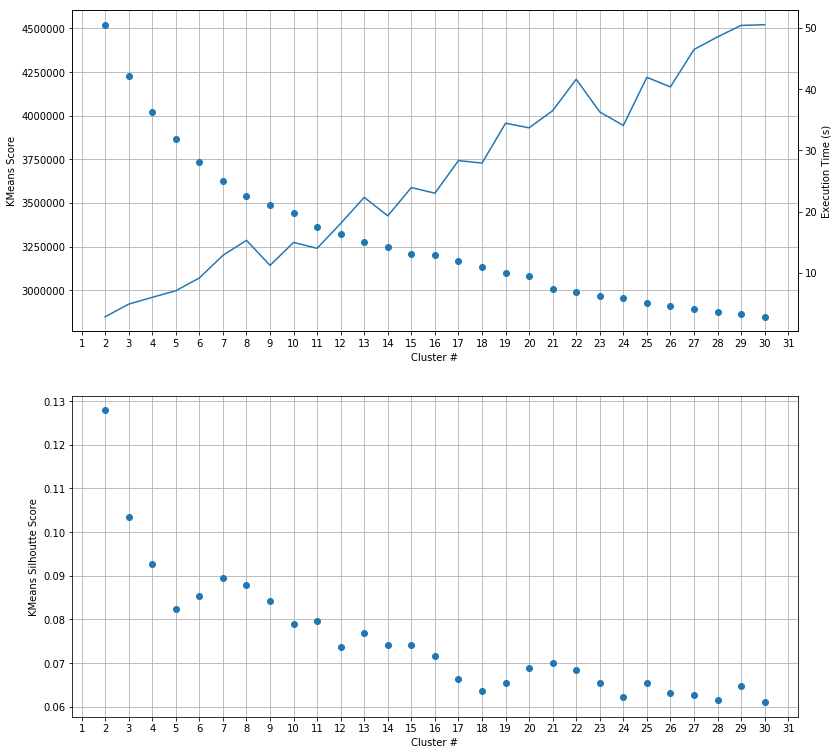

In [97]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
                               
fig, ax = plt.subplots(2,1,figsize=(13,13))

ax[0].plot(n_clusters,sse,'o')

axt = ax[0].twinx()
axt.plot(n_clusters,exe_times)

ax[0].xaxis.set_major_locator(MultipleLocator(1))

ax[0].set_ylabel('KMeans Score')
axt.set_ylabel('Execution Time (s)')
ax[0].set_xlabel('Cluster #')
ax[0].grid(True)

ax[1].plot(n_clusters,s_scores,'o')
ax[1].set_ylabel('KMeans Silhoutte Score')
ax[1].set_xlabel('Cluster #')
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].grid(True)

In [102]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans

km = KMeans(n_clusters=8)

model = km.fit(az_pca)
az_pred = model.predict(az_pca)

### Discussion 3.1: Apply Clustering to General Population

The computing time for each KMeans fit was too long, which is why we decided to reduce to a randomized set of rows with 10% of the original counts of rows for the fitting.

Deciding the optimal number of clusters is a difficulat problem based on the SSE. There is no obvious ellbow 'knee' to choose. There seems to be a slight discontinuity around the 7-10 region though.

Using the silhoutte score does not give a definitive answer either, since it indicates using the lowest number of clusters possible. However, the score has a local maximum in the region where the SSE also indicates a discontinuity, so we choose 8.

A better scoring methodology or scaling might give a better indicating of the optimal number of clusters to use.

### Step 3.2: Apply All Steps to the Customer Data

In [103]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';') 

In [104]:
clean_cust, cust_del_rows = clean_data(customers)

In [105]:
imp_cust_sca = imputer.transform(clean_cust)
temp_df = pd.DataFrame(imp_cust_sca,columns=clean_cust.columns)

In [115]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_cust, cust_del_rows = clean_data(customers)
imp_cust_sca = imputer.transform(clean_cust)
temp_df = pd.DataFrame(imp_cust_sca,columns=clean_cust.columns)
cust_sca = scaler.transform(temp_df)
cust_sca_pca = pca.transform(cust_sca)
cust_pred = km.predict(cust_sca_pca)

### Step 3.3: Compare Customer Data to Demographics Data

In [107]:
cust_pred_df=np.append(cust_pred,(np.full((len(cust_del_rows)), 8)))
df_cust = pd.DataFrame(cust_pred_df,columns=['Cluster'])
#Only for Barplot
df_cust_bp = pd.DataFrame(df_cust['Cluster'].value_counts(normalize=True))

In [108]:
az_pred_df = np.append(az_pred,(np.full((len(cleanaz_del_rows)), 8)))
df_az = pd.DataFrame(az_pred_df,columns=['Cluster'])
#Only for Barplot
df_az_bp = pd.DataFrame(df_az['Cluster'].value_counts(normalize=True))

Text(0,0.5,'Proportion')

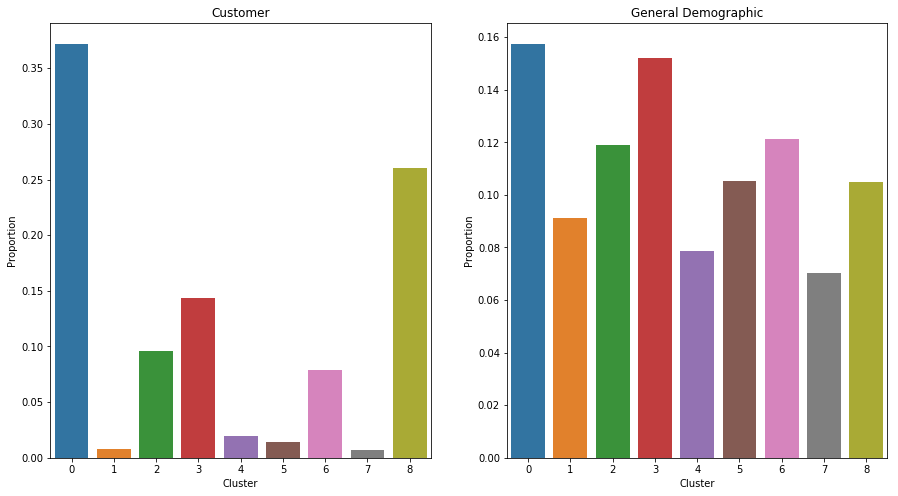

In [109]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
import seaborn as sb

fig, ax = plt.subplots(1,2,figsize=(15,8))
sb.barplot(ax=ax[0],x=df_cust_bp.index,y='Cluster',data=df_cust_bp)
sb.barplot(ax=ax[1],x=df_az_bp.index,y='Cluster',data=df_az_bp)

ax[0].set_title('Customer')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Proportion')

ax[1].set_title('General Demographic')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Proportion')

In [110]:
(df_cust_bp-df_az_bp).idxmax() # Overrepresented in customer set

Cluster    0
dtype: int64

In [113]:
(df_cust_bp-df_az_bp).idxmin()# Underrepresented in customer set

Cluster    5
dtype: int64

In [112]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

dat = pca.inverse_transform(km.cluster_centers_[0])
overrep = pd.DataFrame({'Unscaled':scaler.inverse_transform(dat), 'Scaled': dat},index=scaledaz.columns)
overrep.sort_values(by='Scaled').iloc[np.r_[0:10, -10:0]]

,Unscaled,Scaled
ANREDE_KZ,1.001339,-1.041235
SEMIO_KAEM,2.728976,-0.838103
FINANZ_HAUSBAUER,2.038223,-0.764377
HH_EINKOMMEN_SCORE,3.267762,-0.741758
SEMIO_RAT,2.757704,-0.687265
PLZ8_ANTG3,0.938970,-0.675142
FINANZ_SPARER,1.739981,-0.657189
WEALTH,2.315743,-0.648752
SEMIO_DOM,3.384632,-0.640537
FINANZ_ANLEGER,1.903794,-0.636279


In [114]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

dat = pca.inverse_transform(km.cluster_centers_[5])
underrep = pd.DataFrame({'Unscaled':scaler.inverse_transform(dat), 'Scaled': dat},index=scaledaz.columns)
underrep.sort_values(by='Scaled').iloc[np.r_[0:10, -10:0]]

,Unscaled,Scaled
ALTERSKATEGORIE_GROB,1.791156,-0.987807
SEMIO_VERT,2.502743,-0.912207
FINANZ_VORSORGER,2.296607,-0.825270
SEMIO_SOZ,2.685198,-0.749570
RETOURTYP_BK_S,2.603758,-0.578744
FINANZ_MINIMALIST,2.261870,-0.578554
PLZ8_BAUMAX,1.122101,-0.571363
PLZ8_ANTG3,1.045308,-0.565778
PLZ8_ANTG4,0.296471,-0.562018
EWDICHTE,3.032051,-0.527980


### Discussion 3.3: Compare Customer Data to Demographics Data

- Overrepresented cluster
Judging based on the overrepresented cluster, the features FINANZ_MINIMALIST, SEMIO_VERT, MOBI_REGIO are associated with a customer more then they are represented in the average population. Relatively, there is a high financial interest (low affinity for low interest), less affinity for a dreamful mindset and low movement. It seems more men than women are customers. KBA05_ANTG1 and PLZ8_ANTG1 have larger weight than others indicating more customers in houses with less families.

- Underrepresented cluster
The underrepresented cluster has weights on FINANZ_ANLEGER, SEMIO_TRADV and SEMIO_RAT. This indicates a low affinity for investing. A high SEMIO_TRADV and SEMIO_RAT denote a low association with a traditional and rational mindset. This cluster seems to be predominantly women (which is a good sanity check vs. the overrepresented cluster).

Conclusion

It seems that targeting the overrepresented cluster could benefit the company as the analysis shows distinct features being overrepresented relative to the general population. However, the clustering method should be investigated more thoroughly to have a more reliable metric for choosing a good number clusters. Checking the robustness of the analysis with varying the cluster_counts could help getting more confidence in the analysis.